# Introduction

This notebook demonstrates how to use Haiku topic modeling framework for NMF topic modeling task. There are three basic steps described in the following implementations. 
1. preprocess raw documents using Haiku, and build a dataset containing necessary preprocessed data (i.e. text with stopword, without stopword, lemmatized text, tfidf, etc.) for later use.
2. run NMF algorithm with simple parameters, and choose the best # of topics from optimization process.
3. use NMF generated model for topic prediction and query of similar documents from the original corpus.

This step is to reveal the topic trend insight
4. run topic trending over time with NMF model.

The process will generate pickled models (tfidf, w2v, NMF model), topic clouds, topic/keyword/doc matrix tables, and other visualized image files for post analysis.

#### supress warning messages

In [1]:
# -*- coding: utf-8 -*-
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import os
import pandas as pd
import numpy as np
import pickle

# plotting
import webbrowser as wb
import pyLDAvis
import matplotlib
import matplotlib.pyplot as plt

# sklearn
from pprint import pprint
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim

# haiku
import haiku
from haiku.TextPreprocess import TextPreprocess
from haiku.topic_modeling.common import Dataset, build_dataset
import haiku.topic_modeling.common as tm_common
import haiku.topic_modeling.nmf_sklearn as tm_nmf_sklearn

### Text preprocessing:
1. detect langage, and only store english texts
2. remove punctuation, and unneeded code
3. To be investigated: replace with known correct words

However, removing stop words and lemmatizing texts will be done later, in a common function.

In [21]:
exepath = os.path.dirname(os.path.realpath('__file__'))
data_dir = os.path.join(exepath, 'data')
text_filename = os.path.join(data_dir, 'chat_sessions_dtm.csv')
with open(text_filename, "r", encoding='utf-8') as ins, open(text_filename + '_new.csv', 'w', encoding='utf-8') as outs:
    array = []
    count = 0
    for line in ins:
        sents = line.split(',')
        new_line = sents[0] + ',' + '\t'.join(sents[i] for i in range(1, len(sents)))
        try:
            outs.write(new_line)
        except:
            count += 1
            print(count)

In [22]:
def preprocess_textfile(datadir, text_filename):
    tp = TextPreprocess()
    texts = []
    verbatim = pd.read_csv(os.path.join(datadir, text_filename + '.csv'), encoding = "ISO-8859-1")
    # generating following files for validation / debugging purpose
    output1 = os.path.join(datadir, text_filename + '_en1.csv')
    output2 = os.path.join(datadir, text_filename + '_en2.csv')
    output3 = os.path.join(datadir, text_filename + '_en3.csv')
    with open(output1, 'w', encoding='utf-16') as fw1, open(output2, 'w', encoding='utf-16') as fw2, open(output3, 'w', encoding='utf-16') as fw3:
        # this only applies to ASAT data
        dtime = []
        for i, row in enumerate(verbatim.values):
            if len(row) > 1:
                # assuming targeted text is the last column (or, the first column)
                text = row[len(row) - 1]
            else:
                text = row[0]
                
            lang = tp.detect_language(text)
            if lang == 'en':
                # convert to lower case and trim start/end
                text = text.strip().lower()

                fw1.write(text + '\n')
                if len(row) > 1:
                    dtime.append(row[0])

                text = tp.remove_punctuation(text)
                fw2.write(text + '\n')

                text = tp.replace_phrases(text)
                # supposed to cover this: text = text.replace('#N#', ' ')
                word_count = len(text.split())
                fw3.write(str(word_count) + '\t' + text + '\n')
                                            
                texts.append(text)
    return texts, dtime

### preprocess raw text

In [30]:
dataset_name = 'chat_sessions_dtm_new'

# in notebook you have to use '__file__', instead of __file__
exepath = os.path.dirname(os.path.realpath('__file__'))
data_dir = os.path.join(exepath, 'data')

clean_texts_with_stopwords, dtime = preprocess_textfile(data_dir, dataset_name)
text_filename = os.path.join(data_dir, dataset_name + '_en1.csv')
raw_documents = []
with open(text_filename ,"r", encoding="utf-16") as fin:
    for line in fin.readlines():
        # convert to lowercase
        raw_documents.append(line.strip().lower())
print("Read %d raw text documents" % len(raw_documents))

Read 9472 raw text documents


### initializing parameters

In [31]:
least_term_frequency = 20;

In [32]:
'''
define your own Vectorizer for feature extractions
'''
vec_model = TfidfVectorizer(analyzer='word',       
                                    min_df=least_term_frequency,                    # minimum reqd occurences of a word 
                                    stop_words="english",             # remove stop words, optional as it is supposed to be removed already
                                    lowercase=True,                   # convert all words to lowercase
                                    token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                                    # max_features=50000,             # max number of uniq words
                                    )

### Build data
In this function it will do removing stopwords, lemmatizing words, and create all necessary data sets for further processing or analysis

#### build_dataset function parameters:
    clean_texts_with_stopwords - from raw text, detected non-english documents are filtered out. In the English documents, punctuations and other speical text are removed.
    raw_documents - English documents closest to raw data
    data_dir - specified folder to store all output data
    dataset_name - specified output folder name
    vec_model - custom vectorizer function pointer, i.e. feature extraction functions
    w2v_model - custom word2vec model for coherence measurement, if "None", it uses existing input corpus to build w2v model
    least_term_frequency - minimum frequency of terms to be captured in dictionary
    initial_topics_k - starting number of topics

In [33]:
dataset = build_dataset(clean_texts_with_stopwords, raw_documents, data_dir, dataset_name, vec_model, None, least_term_frequency)

creating custom vectorizer...
Sparsicity:  4.204305244057082 %
Created 9472 X 2856 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=20,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='[a-zA-Z0-9]{3,}', tokenizer=None, use_idf=True,
        vocabulary=None)-normalized document-term matrix
Vocabulary has 2856 distinct terms
01. quot (963.31)
02. account (814.26)
03. thank (682.47)
04. support (594.85)
05. chat (587.24)
06. namepii (539.52)
07. window (525.69)
08. xbox (501.17)
09. microsoft (493.15)
10. office (416.07)
11. email (412.26)
12. help (401.61)
13. game (400.86)
14. command (383.45)
15. know (373.42)
16. try (362.71)
17. issue (361.99)
18. contact (347.44)
19. refund (344.00)
20. good (343.04)
Model has 528

### define custom parameters

In [34]:
if dtime != []:
    dataset.dtime = dtime

In [36]:
dataset.config = tm_common.Config()
dataset.config.kmin = 10
dataset.config.kmax = 20
dataset.config.kstep = 1

# experimenting with more paramters:
#  { 'init' : 'nndsvd', 'solver' : 'mu', 'beta_loss' : 'frobnius', 'max_iter' : 200, 'l1_ratio' : 0, 'alpha' : 0 }
# solver 'cd' does not handle beta_loss = 'kullback-leibler'
# beta_loss = 'kullback-leibler'. default beta_loss = 'frobenius'
# and other parameters specific to the topic modeling API

#Ensure this line has been declared: from sklearn.decomposition import NMF
# example(1)
#dataset.myfunc = NMF(init = 'nndsvd', n_components = 10, solver = 'mu', beta_loss = 'kullback-leibler')
#dataset.myfunc_optimization = lambda k: NMF(init = 'nndsvd', n_components = k, solver = 'mu', beta_loss = 'kullback-leibler')

# example(2)
#dataset.myfunc = lambda: NMF(init = None, n_components = 10, solver = 'cd', beta_loss='frobenius')
#dataset.myfunc_optimization = lambda k: NMF(init = None, n_components = k, solver = 'cd', beta_loss='frobenius')

Using NMF with sklearn......
Optimizing NMF model with topics #...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
K=10: 
Coherence(w2v)=0.3761

Coherence Score(u_mass):  -0.8695732176165973

Coherence Score(c_v):  0.6276952885808452

Coherence Score(c_uci):  0.6803943854491219


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9472 samples in 0.010s...
[t-SNE] Computed neighbors for 9472 samples in 1.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9472
[t-SNE] Computed conditional probabilities for sample 2000 / 9472
[t-SNE] Computed conditional probabilities for sample 3000 / 9472
[t-SNE] Computed conditional probabilities for sample 4000 / 9472
[t-SNE] Computed conditional probabilities for sample 5000 / 9472
[t-SNE] Computed conditional probabilities for sample 6000 / 9472
[t-SNE] Computed conditional probabilities for sample 7000 / 9472
[t-SNE] Computed conditional probabilities for sample 8000 / 9472
[t-SNE] Computed conditional probabilities for sample 9000 / 9472
[t-SNE] Computed conditional probabilities for sample 9472 / 9472
[t-SNE] Mean sigma: 0.013521
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.657440
[t-SNE] Error after 1000 iterations: 1.512624
0 -33.03068923950195 32.33159637451172 ['click

[t-SNE] Computed conditional probabilities for sample 2000 / 9472
[t-SNE] Computed conditional probabilities for sample 3000 / 9472
[t-SNE] Computed conditional probabilities for sample 4000 / 9472
[t-SNE] Computed conditional probabilities for sample 5000 / 9472
[t-SNE] Computed conditional probabilities for sample 6000 / 9472
[t-SNE] Computed conditional probabilities for sample 7000 / 9472
[t-SNE] Computed conditional probabilities for sample 8000 / 9472
[t-SNE] Computed conditional probabilities for sample 9000 / 9472
[t-SNE] Computed conditional probabilities for sample 9472 / 9472
[t-SNE] Mean sigma: 0.015610
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.157295
[t-SNE] Error after 1000 iterations: 1.514516
0 -44.039859771728516 22.123483657836914 ['click remote computer update access issue file run download connect']
1 -1.6625202894210815 -16.475149154663086 ['quot command ping namepii ita dona gamertag cana say today']
2 6.423552513122559 -31.25710678100

12 -61.64161682128906 14.6519775390625 ['key product activate purchase window license alphanumericpii activation validate pro']
13 -4.930734157562256 31.290218353271484 ['email outlook send address com mail emailpii receive code gmail']
14 -37.453712463378906 21.06645965576172 ['remote click access computer code connect file run download personal']
amp : sdk <class 'KeyError'>
rejoin : sdk <class 'KeyError'>
true : sdk <class 'KeyError'>
smc : sdk <class 'KeyError'>
https : sdk <class 'KeyError'>
com : sdk <class 'KeyError'>
visitid : sdk <class 'KeyError'>
partnerid : sdk <class 'KeyError'>
link : sdk <class 'KeyError'>
K=16: 
Coherence(w2v)=0.3814

Coherence Score(u_mass):  -1.2056051137448631

Coherence Score(c_v):  0.6297391840897566

Coherence Score(c_uci):  0.6428664819428578
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9472 samples in 0.059s...
[t-SNE] Computed neighbors for 9472 samples in 2.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9472


[t-SNE] Computed conditional probabilities for sample 6000 / 9472
[t-SNE] Computed conditional probabilities for sample 7000 / 9472
[t-SNE] Computed conditional probabilities for sample 8000 / 9472
[t-SNE] Computed conditional probabilities for sample 9000 / 9472
[t-SNE] Computed conditional probabilities for sample 9472 / 9472
[t-SNE] Mean sigma: 0.019507
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.210968
[t-SNE] Error after 1000 iterations: 1.601890
0 16.93877410888672 31.915428161621094 ['update issue computer window device try driver restart version fix']
1 -24.09090805053711 24.444122314453125 ['quot command namepii ita dona gamertag cana say today didna']
2 9.6030855178833 -20.385509490966797 ['game play xbox purchase namepii try buy download decay know']
3 -13.465417861938477 -7.35167121887207 ['account sign password email use com log microsoft access security']
4 -38.318458557128906 8.313499450683594 ['office install home version word mac product subs

4 -26.044748306274414 2.3514678478240967 ['office install home version word mac product subscription business instal']
5 15.641999244689941 -44.59419250488281 ['refund purchase process request thank item account order check money']
6 -16.664649963378906 -45.84209060668945 ['skype number credit username chat visit use email code thank']
7 9.313450813293457 9.449613571166992 ['support chat window thank microsoft contact today good session help']
8 -26.574596405029297 -8.565841674804688 ['amp rejoin true smc https com visitid partnerid link sdk']
9 -0.3234209418296814 -43.19593811035156 ['card purchase code credit payment gift redeem account add buy']
10 0.17980042099952698 -10.633821487426758 ['enforcement ban suspension xbox team report action case account suspend']
11 24.978445053100586 9.932903289794922 ['xbox console reset home power thank setting gamertag set support']
12 -50.70512390136719 15.34525203704834 ['key product activate window license purchase activation validate pro buy'

 'alphanumericpii' 'activation' 'validate' 'pro']
6060  :  thanks for contacting microsoft support	 my name is {namepii} kumar v   please allow me a few moments while i review the information you provided  please be aware that if you switch application or change focus to another window while working with us	 you may get disconnected from your chat session  

Topic #14: ['email' 'outlook' 'send' 'address' 'com' 'mail' 'emailpii' 'receive'
 'code' 'gmail']
628  :  hi my outlook shows wrong date in the messages

Topic #15: ['remote' 'click' 'access' 'computer' 'code' 'connect' 'file' 'run'
 'download' 'personal']
6583  :  hello  mirzah   hello  mirzah   hello hi i used private tab but still the same error i used private tab but still the same error \ \ this is bikash from microsoft escalation team  this is bikash from microsoft escalation team  hello hello have you tried on a different computer  have you tried on a d


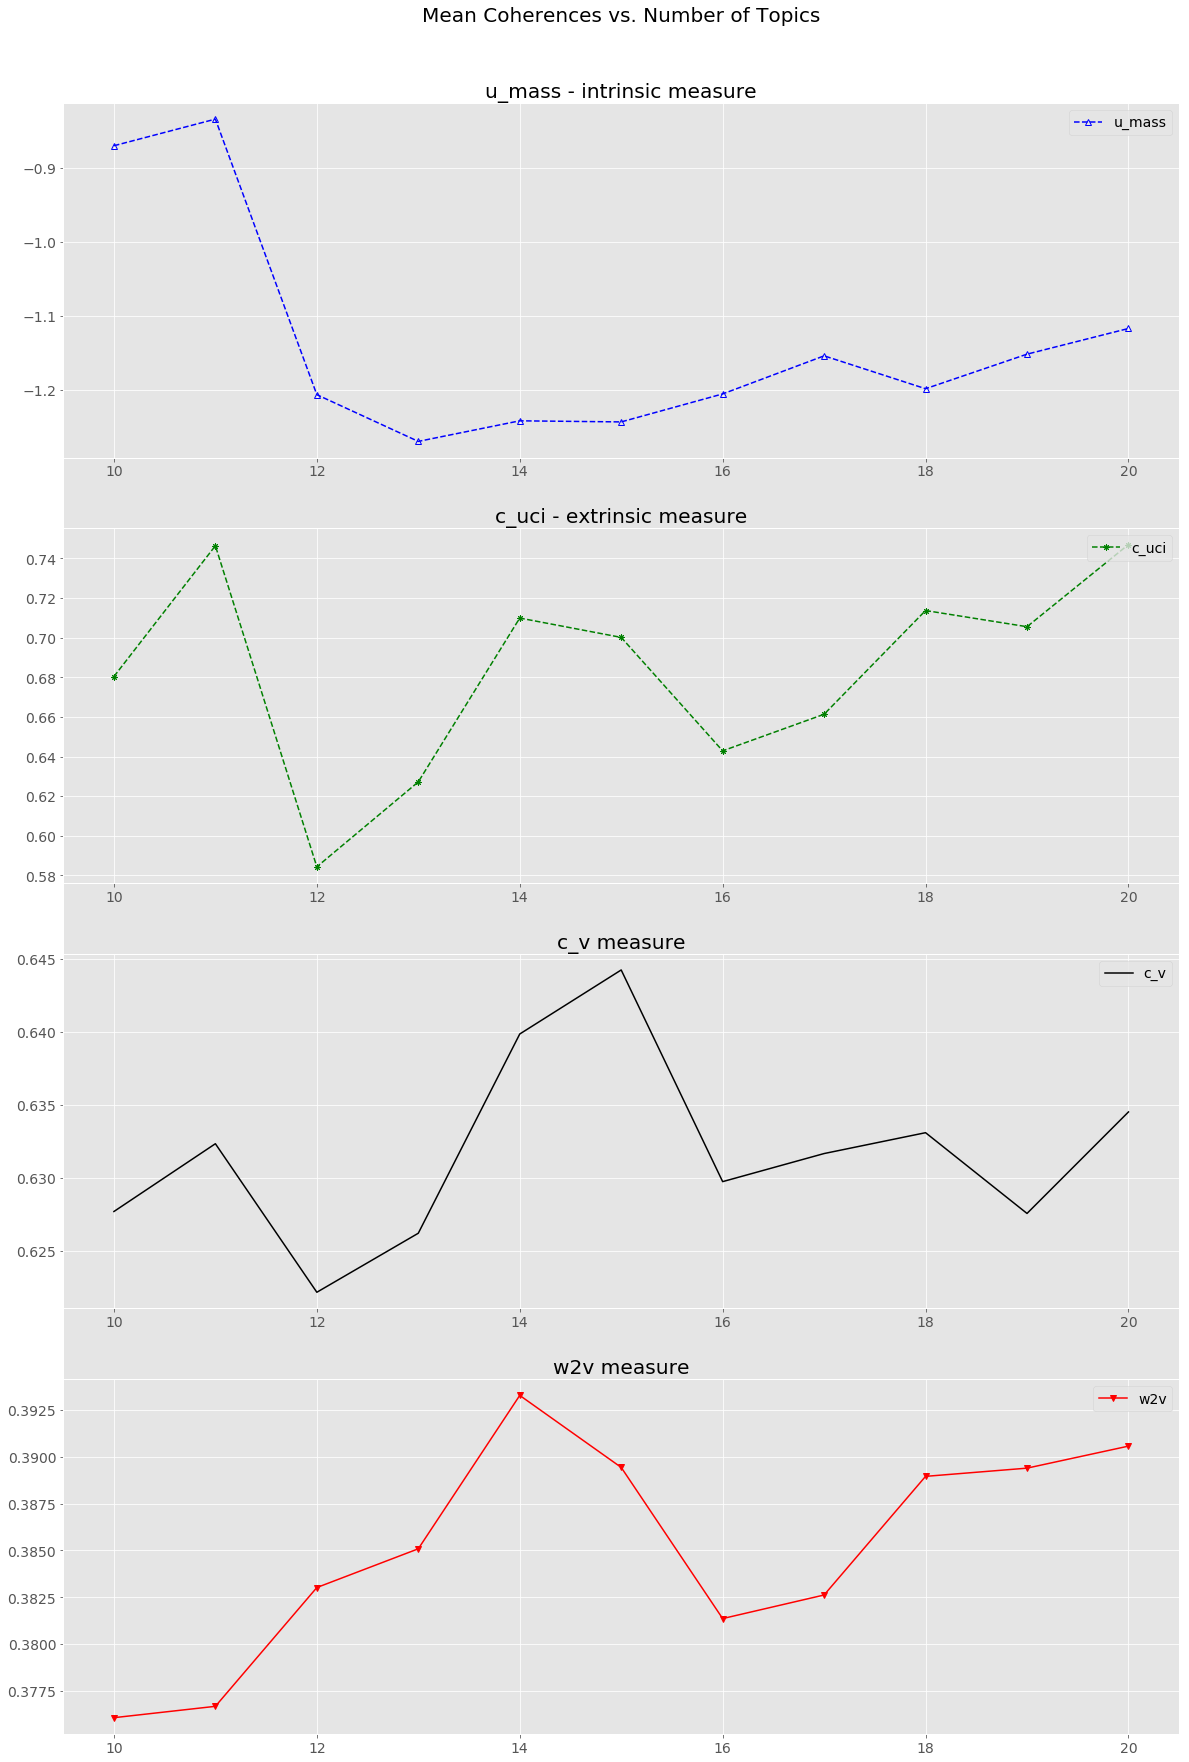

In [37]:
model = tm_nmf_sklearn.create_model(dataset, True)

### Run topics over time model 

compare the DTM results among three models (NMF, LDA sklearn, and LDA gensim)


Topic #1: ['click' 'remote' 'computer' 'update' 'access' 'issue' 'file' 'run'
 'download' 'window']
4956  :  hi	 how are you doing today  thanks for contacting microsoft support	 my name is {namepii} {namepii} {namepii}   please allow me a few moments while i review the information you provided  please be aware that if you switch application or change focus to another window while working with us	 you may 

Topic #2: ['quot' 'command' 'ping' 'namepii' 'ita' 'dona' 'gamertag' 'cana' 'say'
 'today']
3652  :  please be aware that if you switch application or change focus to another window while working with us	 you may get disconnected from your chat session  to ensure the best support experience	 please stay active in this chat window  thank you for contacting microsoft support  i am {namepii} joy g  ho

Topic #3: ['game' 'play' 'xbox' 'console' 'purchase' 'try' 'namepii' 'buy' 'issue'
 'store']
570  :  please be aware that if you switch application or change focus to another window whi

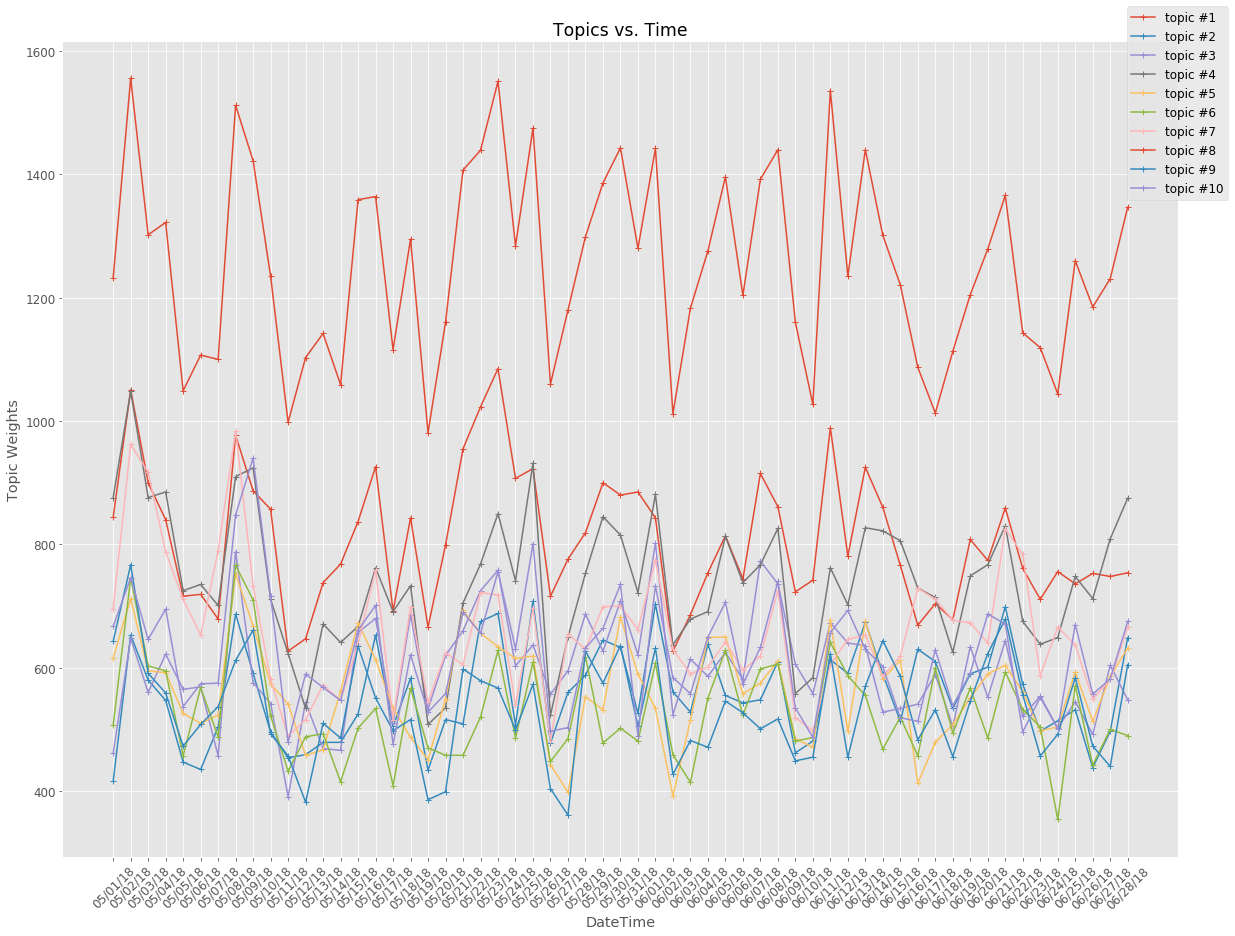

In [38]:
if dataset.dtime != None:
    dataset.topics_k = 10  
    tm_nmf_sklearn.review_dtm(dataset)

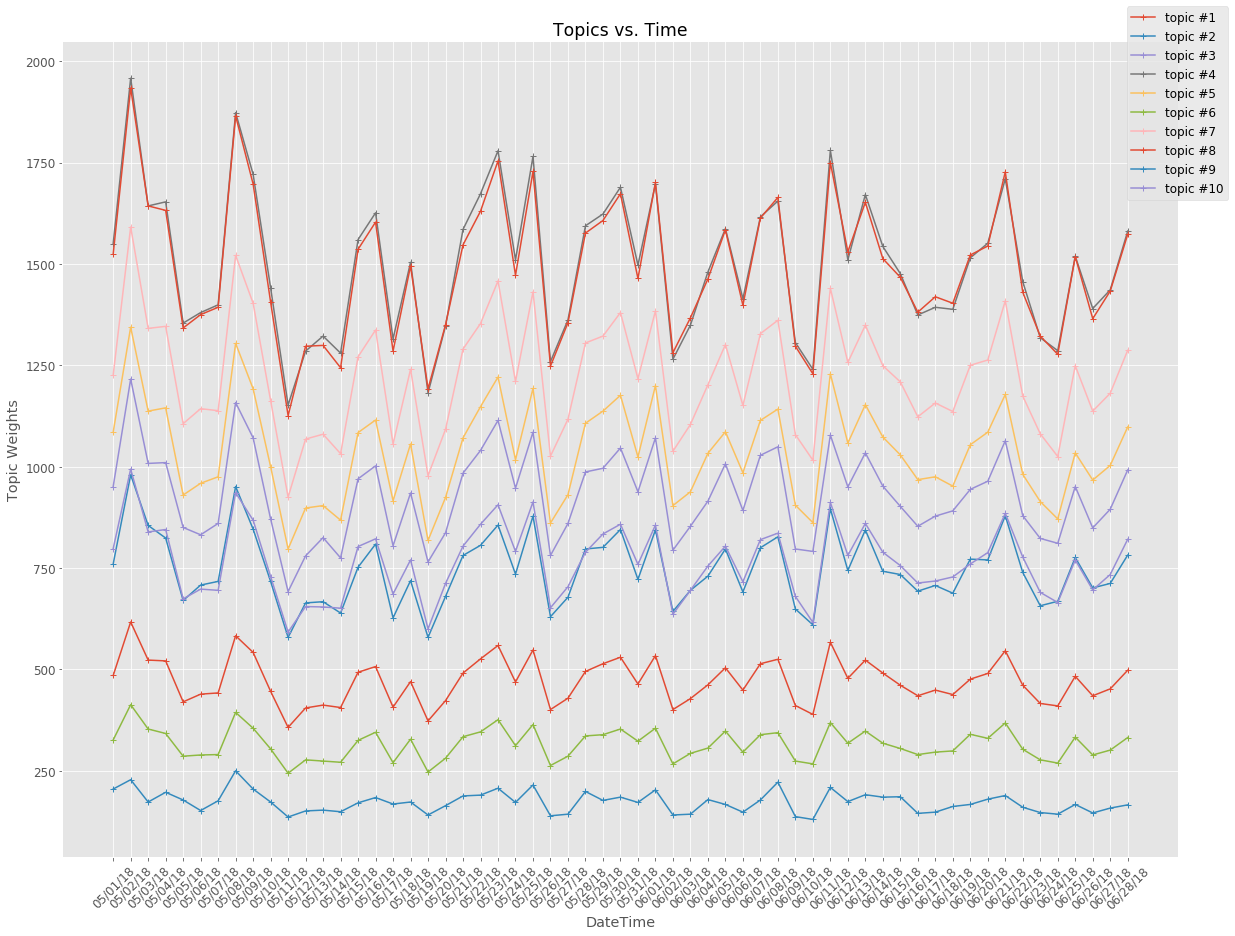

In [39]:
import haiku.topic_modeling.lda_sklearn as tm_lda_sklearn

if dataset.dtime != None:
    dataset.topics_k = 10  
    tm_lda_sklearn.review_dtm(dataset)

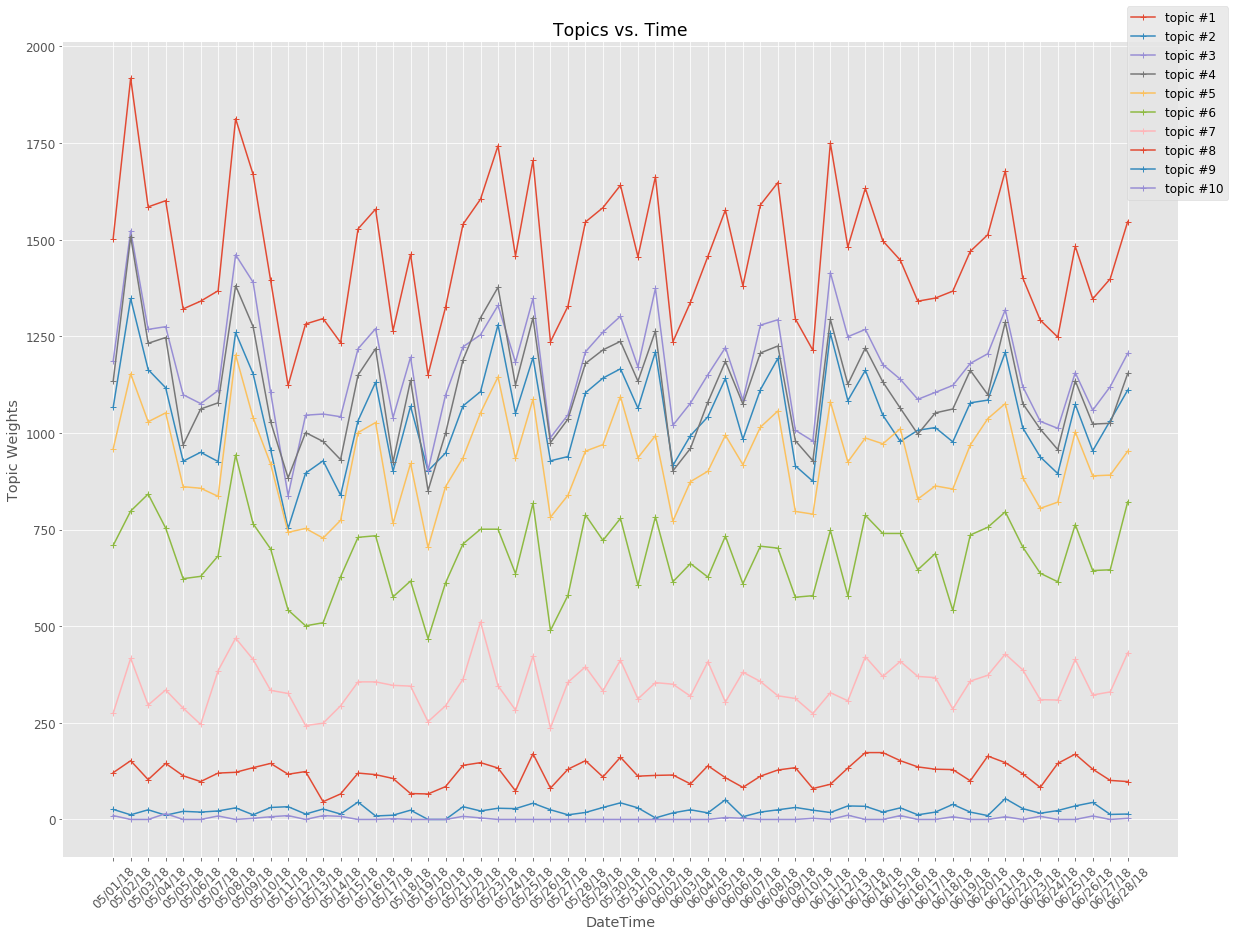

In [40]:
import haiku.topic_modeling.lda_gensim as tm_lda_gensim

if dataset.dtime != None:
    dataset.topics_k = 10  
    tm_lda_gensim.review_dtm(dataset)